In [63]:
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold

FIG_DIR = Path("../res/ML_Exercises/GB500/exercise_list_2/report/figures/")

# Model definition

Let's define a Classfier neural net class that makes it easier to experiment with different layer configurations.

In [2]:
class ClassifierNN(nn.Module):

    def __init__(self, input_size: int, output_size: int, architecture: list[int]):
        """
        Takes a neural net architecture representation as a list 
        and instantiate a classifier neural net with the proposed 
        layer layout.

        Exemple: ClassifierNN(2, 2, [4, 3]) with create a neural net
        with 4 layers, a input layer with 2 neurons, 2 hidden layers
        with 4 and 3 neurons and an output layer with 2 neurons.

        Parameters
        ----------

        input_size: int
            Size of the input for the net

        output_size: int
            Size of the output for the net

        architecture: list[int]
            list with integers defining each hidden layer size.
        """
        super().__init__()

        if len(architecture) < 1:
            raise ValueError("It's necessary at least 1 hidden layer to form a network")

        architecture = [input_size] + architecture

        self.nn = nn.Sequential()

        # Composing layers
        for a, b in zip(architecture, architecture[1:]):
            self.nn.append(nn.Linear(a, b))
            self.nn.append(nn.ReLU())

        # Last layer
        self.nn.append(nn.Linear(architecture[-1], output_size))
        self.nn.append(nn.Softmax(dim=1))
            
        
        
    def forward(self, x):
        return self.nn(x) 

Let's test to see whether it gives the desired layout!

In [3]:
ClassifierNN(4, 3, [6, 5, 8])

ClassifierNN(
  (nn): Sequential(
    (0): Linear(in_features=4, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
    (7): Softmax(dim=1)
  )
)

In [4]:
def accuracy(model, x, y):
    """
    Given a model, with features and target varible, 
    calculate accuracy of the model on that data
    """
    
    with torch.no_grad():

        y_pred = model.forward(x)

        acc = torch.sum(torch.argmax(y_pred, axis=1) == torch.argmax(y, axis=1)).item()/x.shape[0]

    return acc

# Data Loading and exploration

Let's first load our data and verify if it's balanced, missing info, etc.

In [5]:
data = pd.read_csv("breast_cancer.csv").iloc[:, :-1].drop("id", axis=1)
data.sample(frac=0.01)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
109,B,11.34,21.26,72.48,396.5,0.08759,0.06575,0.05133,0.01899,0.1487,...,13.01,29.15,83.99,518.1,0.1699,0.2196,0.3120,0.08278,0.2829,0.08832
24,M,16.65,21.38,110.00,904.6,0.11210,0.14570,0.15250,0.09170,0.1995,...,26.46,31.56,177.00,2215.0,0.1805,0.3578,0.4695,0.20950,0.3613,0.09564
73,M,13.80,15.79,90.43,584.1,0.10070,0.12800,0.07789,0.05069,0.1662,...,16.57,20.86,110.30,812.4,0.1411,0.3542,0.2779,0.13830,0.2589,0.10300
141,M,16.11,18.05,105.10,813.0,0.09721,0.11370,0.09447,0.05943,0.1861,...,19.92,25.27,129.00,1233.0,0.1314,0.2236,0.2802,0.12160,0.2792,0.08158
170,B,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,...,13.50,15.64,86.97,549.1,0.1385,0.1266,0.1242,0.09391,0.2827,0.06771
385,M,14.60,23.29,93.97,664.7,0.08682,0.06636,0.08390,0.05271,0.1627,...,15.79,31.71,102.20,758.2,0.1312,0.1581,0.2675,0.13590,0.2477,0.06836


In [6]:
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


This data contains variables that has different ranges. Normalization will be necessary.

<Axes: xlabel='diagnosis'>

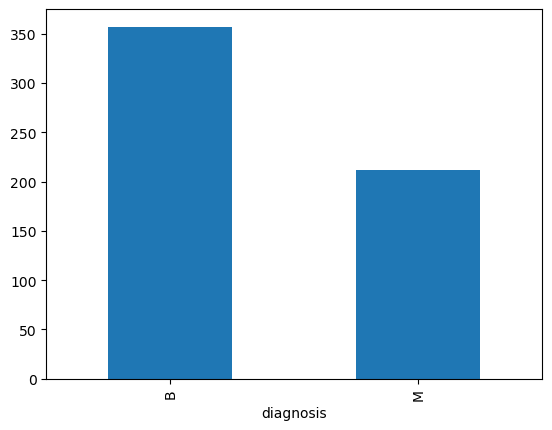

In [7]:
data.diagnosis.value_counts().plot.bar()

There is an unbalance on the data. Let's use the simplest approach, drop data in the class with the most datapoints.

<Axes: xlabel='diagnosis'>

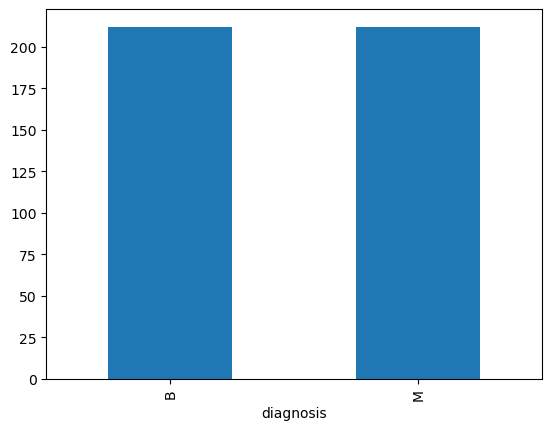

In [8]:
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("breast_cancer.csv").iloc[:, :-1].drop("id", axis=1)

MinMaxScaler

N = np.sum(data.diagnosis == "M").item()

data = pd.concat([data.loc[data.diagnosis == "B"].sample(N), data.loc[data.diagnosis == "M"]])


data.diagnosis.value_counts().plot.bar()

In [33]:
data.drop("diagnosis", axis=1)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
296,10.910,12.35,69.14,363.7,0.08518,0.04721,0.012360,0.013690,0.1449,0.06031,...,11.370,14.82,72.42,392.2,0.09312,0.07506,0.028840,0.03194,0.2143,0.06643
547,10.260,16.58,65.85,320.8,0.08877,0.08066,0.043580,0.024380,0.1669,0.06714,...,10.830,22.04,71.08,357.4,0.14610,0.22460,0.178300,0.08333,0.2691,0.09479
568,7.760,24.54,47.92,181.0,0.05263,0.04362,0.000000,0.000000,0.1587,0.05884,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.000000,0.00000,0.2871,0.07039
327,12.030,17.93,76.09,446.0,0.07683,0.03892,0.001546,0.005592,0.1382,0.06070,...,13.070,22.25,82.74,523.4,0.10130,0.07390,0.007732,0.02796,0.2171,0.07037
525,8.571,13.10,54.53,221.3,0.10360,0.07632,0.025650,0.015100,0.1678,0.07126,...,9.473,18.45,63.30,275.6,0.16410,0.22350,0.175400,0.08512,0.2983,0.10490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,20.920,25.09,143.00,1347.0,0.10990,0.22360,0.317400,0.147400,0.2149,0.06879,...,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.659900,0.25420,0.2929,0.09873
564,21.560,22.39,142.00,1479.0,0.11100,0.11590,0.243900,0.138900,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.410700,0.22160,0.2060,0.07115
565,20.130,28.25,131.20,1261.0,0.09780,0.10340,0.144000,0.097910,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.321500,0.16280,0.2572,0.06637
566,16.600,28.08,108.30,858.1,0.08455,0.10230,0.092510,0.053020,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.340300,0.14180,0.2218,0.07820


In [9]:
y = pd.get_dummies(data.diagnosis).values.astype(np.int8)
x = data.drop("diagnosis", axis=1).values

x = MinMaxScaler().fit_transform(x)

x.shape, y.shape

((424, 30), (424, 2))

# Train, validation, test

In [122]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Model training

ClassifierNN(
  (nn): Sequential(
    (0): Linear(in_features=30, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=2, bias=True)
    (5): Softmax(dim=1)
  )
)


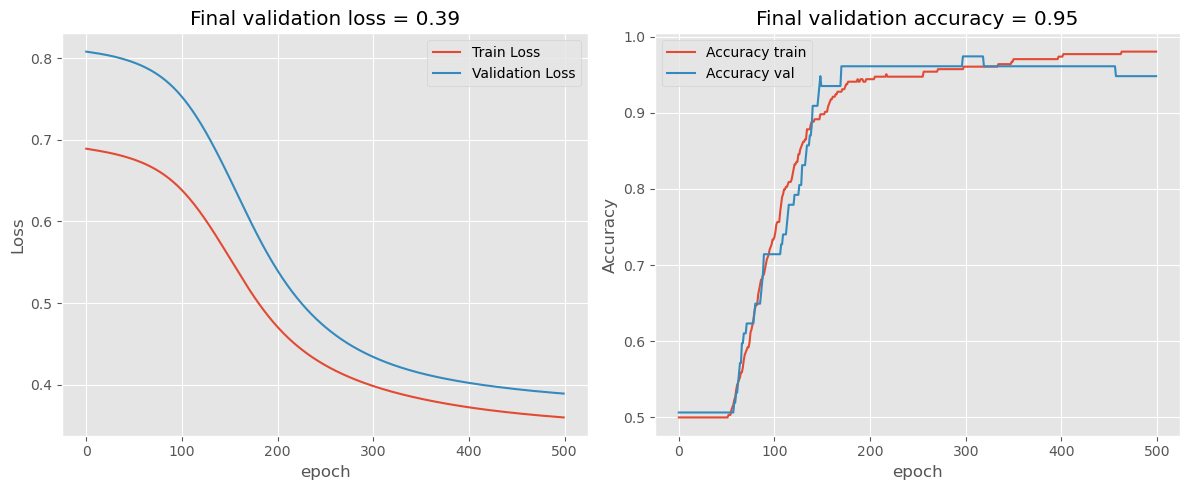

In [137]:
model = ClassifierNN(30, 2, [5, 6])

print(model)
epochs = 500

opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

losses_train = []
losses_val = []

accuracy_train = []
accuracy_val = []



for i in range(epochs):

    y_pred_t = model.forward(x_train)
    loss = loss_fn(y_pred_t, y_train)

    losses_train.append(loss.item())
   
    with torch.no_grad():
        y_pred_v = model.forward(x_val)
        losses_val.append(loss_fn(y_val, y_pred_v).item())
        accuracy_train.append(accuracy(model, x_train, y_train))
        accuracy_val.append(accuracy(model, x_val, y_val))

    
    loss.backward()
    opt.step()
    opt.zero_grad()


plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.plot(losses_train, label="Train Loss")
ax1.plot(losses_val, label="Validation Loss")
ax1.set_title(f"Final validation loss = {losses_val[-1]:.2f}")

ax2.plot(accuracy_train, label="Accuracy train")
ax2.plot(accuracy_val, label="Accuracy val")
ax2.set_title(f"Final validation accuracy = {accuracy_val[-1]:.2f}")

# ax2.text(10, 0.2, "bla")

ax1.legend()
ax2.legend()

ax1.set(ylabel="Loss", xlabel="epoch")
ax2.set(ylabel="Accuracy", xlabel="epoch")

plt.tight_layout()

plt.savefig(FIG_DIR / "train_evolution.png", dpi=100)

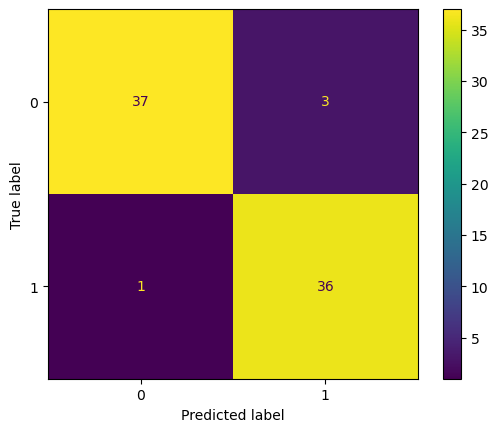

In [146]:
plt.style.use("default")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(torch.argmax(y_pred_v, axis=1), torch.argmax(y_val, axis=1))).plot()
plt.savefig(FIG_DIR / "confusion_mat.png", dpi=100)

# Changes on the optimizer

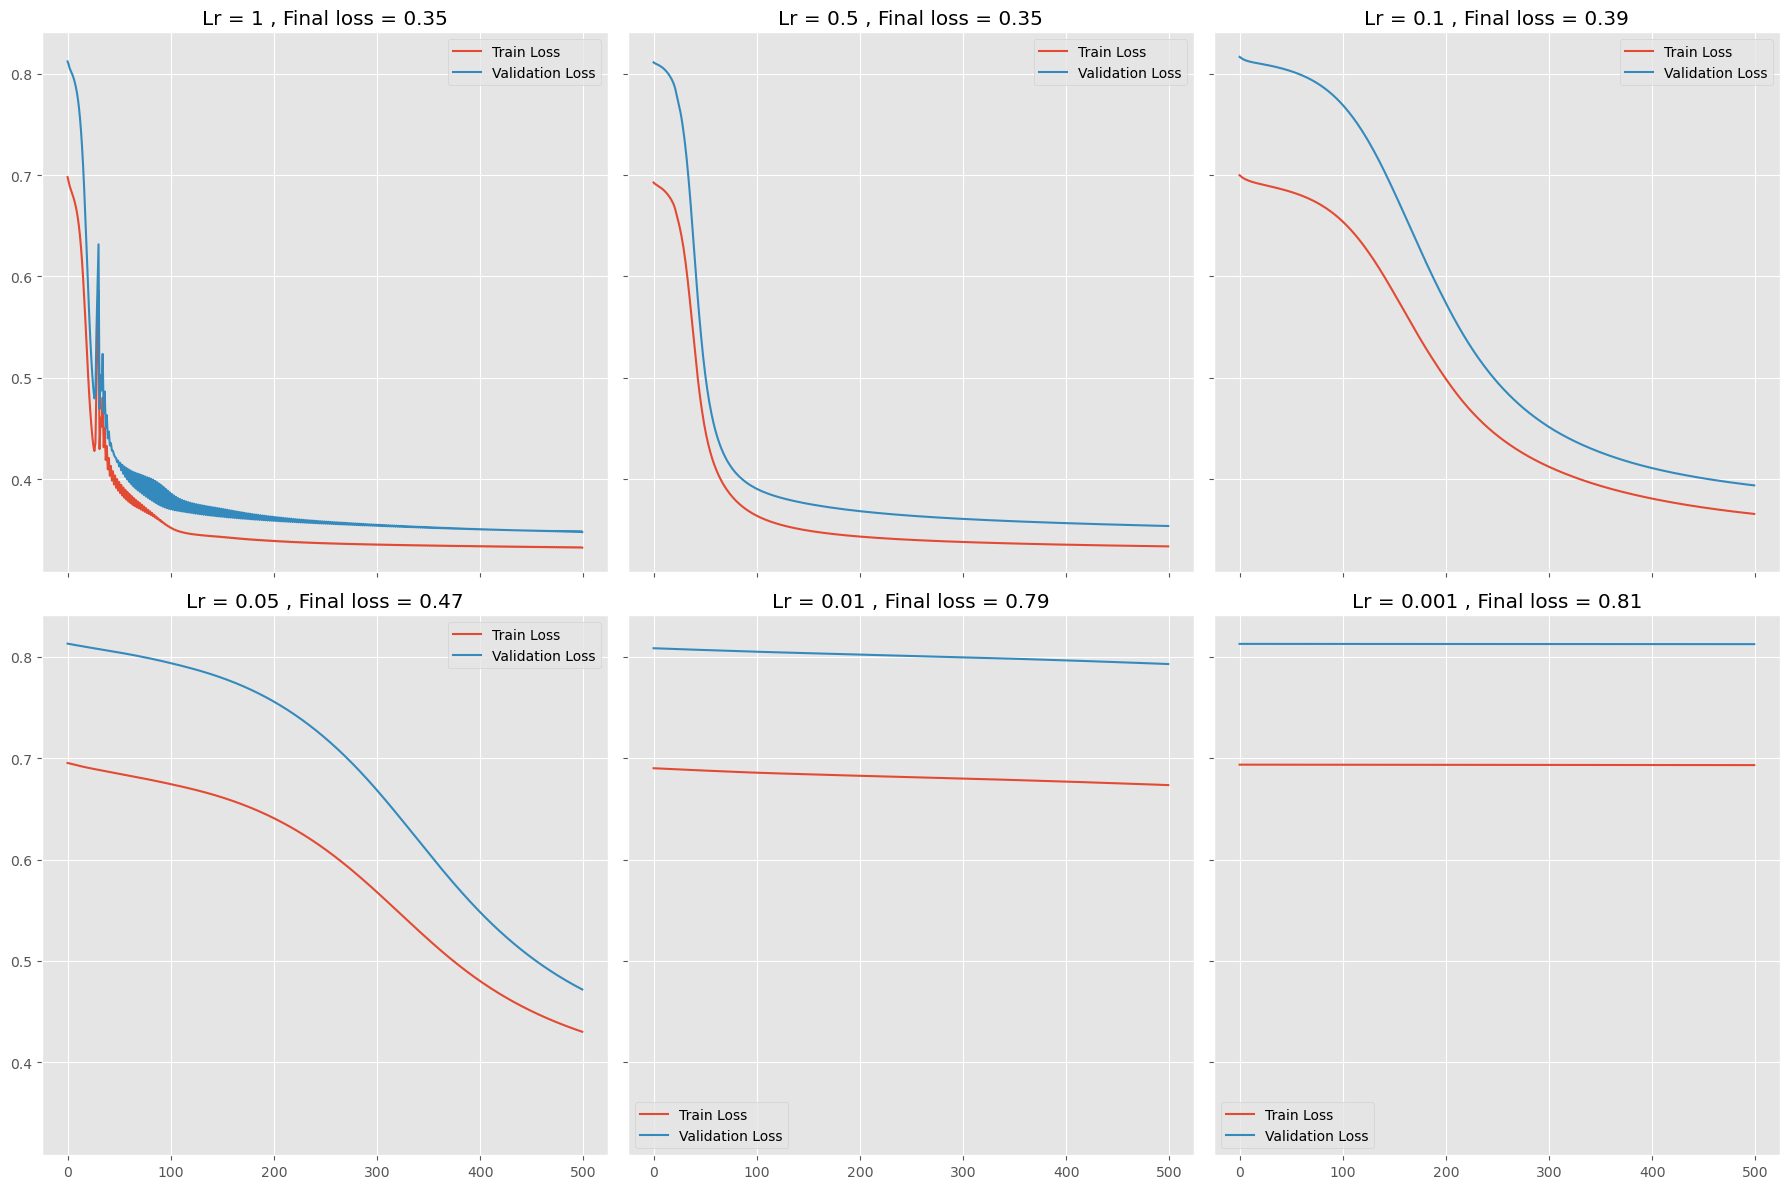

In [136]:
epochs=500

    
plt.style.use("ggplot")
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 12), sharex=True, sharey=True)

acc_val_lr = []

for lr, ax in zip([1, 0.5, 0.1, 0.05, 0.01, 0.001], axes.ravel()):

    model = ClassifierNN(30, 2, [5, 6])
    
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    losses_train = []
    losses_val = []
    
    accuracy_train = []
    accuracy_val = []


    for i in range(epochs):
    
        y_pred_t = model.forward(x_train)
        loss = loss_fn(y_pred_t, y_train)
    
        losses_train.append(loss.item())
       
        with torch.no_grad():
            y_pred_v = model.forward(x_val)
            losses_val.append(loss_fn(y_val, y_pred_v).item())
            accuracy_train.append(accuracy(model, x_train, y_train))
            accuracy_val.append(accuracy(model, x_val, y_val))
    
        
        loss.backward()
        opt.step()
        opt.zero_grad()

    acc_val_lr.append(accuracy_val[-1])

    
    ax.plot(losses_train, label="Train Loss")
    ax.plot(losses_val, label="Validation Loss")
    ax.set_title(f"Lr = {lr} , Final loss = {losses_val[-1]:.2f}")
    
    ax.legend()

    
plt.tight_layout()
# plt.show()

# plt.savefig(FIG_DIR / "different_lr.png", dpi=100)

# K-Fold Cross Validation

Let's now split the data again but with only 3 divisions. Only one for train and other for test. The train split will be further divided on the K-Fold for validation.

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Let's adapt the code from earlier to run on the folds and store the final accuracy.

In [106]:
epochs = 500

kf = KFold(4, shuffle=True)

acc_t = []
acc_v = []
l_t = []
l_v = []

models = []

for k, (train_index, val_index) in enumerate(kf.split(x_train), start=1):

    # Re-start models and optmizer
    model_k = ClassifierNN(30, 2, [5, 6])   
    opt = torch.optim.SGD(model_k.parameters(), lr=0.1)
    loss_fn = nn.CrossEntropyLoss()

    print("Starting:", k)
    
    for i in range(epochs):

        y_pred_t = model_k.forward(x_train[train_index])
        loss = loss_fn(y_pred_t, y_train[train_index])
            
        loss.backward()
        opt.step()
        opt.zero_grad()

       
    with torch.no_grad():
        acc_t.append(accuracy(model_k, x_train[train_index], y_train[train_index]))
        acc_v.append(accuracy(model_k, x_train[val_index], y_train[val_index]))
        l_t.append(loss_fn(model_k.forward(x_train[train_index]), y_train[train_index]).item())
        l_v.append(loss_fn(model_k.forward(x_train[val_index]), y_train[val_index]).item())

    print(acc_t[k-1])
    print(acc_v[k-1])

    print(l_t[k-1])
    print(l_v[k-1])

    models.append(model_k)
        

Starting: 1
0.9508771929824561
0.9583333333333334
0.4158007800579071
0.41222548484802246
Starting: 2
0.9615384615384616
0.968421052631579
0.3800647258758545
0.3715028762817383
Starting: 3
0.951048951048951
0.9473684210526315
0.42754173278808594
0.4409424960613251
Starting: 4
0.9825174825174825
0.9263157894736842
0.3592107594013214
0.3843030333518982


Verifying the statistics ...

In [110]:
np.mean(acc_v).item(), np.std(acc_v).item(), np.median(acc_v).item()

(0.9501096491228069, 0.015625288547658878, 0.9528508771929824)

In [111]:
np.mean(acc_t).item(), np.std(acc_t).item(), np.median(acc_t).item()

(0.9614955220218377, 0.01288220112755067, 0.9562937062937062)